In [37]:
from mmasim.probe.intrinsic.amd_cdna3 import mfma_intrinsics
instruction = mfma_intrinsics["f32_32x32x16_fp8_fp8"]

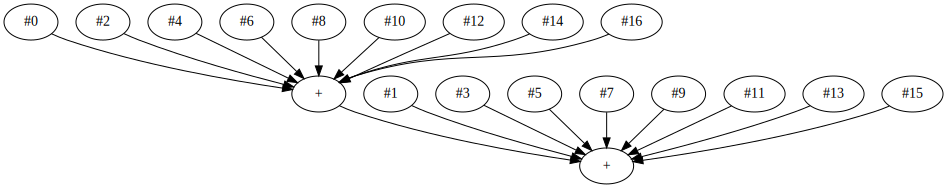

In [38]:
from graphviz import Digraph


class AccumImpl:
    n_summands: int

    def __init__(self): ...
    def set_mask(self, k: int, negative: bool = False): ...
    def reset_mask(self, k: int): ...
    def get_l(self) -> int: ...
    def random_test(self, T: Digraph, n_trials: int) -> bool: ...


def fprev(accum_impl: AccumImpl) -> Digraph:
    T = Digraph()

    def build_subtree(indexes: list[int]) -> tuple[int, int]:
        i = indexes[0]
        T.node(str(i), "#" + str(i))

        if len(indexes) == 1:
            return i, 1

        # calculate L_i
        L_i = []
        accum_impl.set_mask(i, negative=False)
        for j in indexes[1:]:
            accum_impl.set_mask(j, negative=True)
            L_i.append(accum_impl.get_l())
            accum_impl.reset_mask(j)
        accum_impl.reset_mask(i)
        zipped_Li = sorted(zip(L_i, indexes[1:]))
        indexes = [i for _, i in zipped_Li]
        L_i = [x for x, _ in zipped_Li]

        # build the subtree
        current_root = i
        k = 0
        while k < len(indexes):
            cnt = 1
            while k + cnt < len(indexes) and L_i[k + cnt] == L_i[k]:
                cnt += 1
            # J_l == indexes[k : k + cnt]
            root_Tprime, nleaves_Tc = build_subtree(indexes[k : k + cnt])
            if nleaves_Tc == cnt:
                new_root = current_root + accum_impl.n_summands
                T.node(str(new_root), "+")
                T.edge(str(current_root), str(new_root))
                T.edge(str(root_Tprime), str(new_root))
                current_root = new_root
            else:
                T.edge(str(current_root), str(root_Tprime))
                current_root = root_Tprime
            k += cnt
        return current_root, L_i[-1]

    build_subtree(list(range(accum_impl.n_summands)))
    return T


M = 2**7
m = 2**-10
class DotAdd(AccumImpl):
    def __init__(self, k):
        self.n_summands = k+1
        self.a = [-m] * k
        self.b = [m] * k
        self.c = -m*m

    def set_mask(self, k: int, negative: bool=False):
        if k < self.n_summands-1:
            self.a[k] = -M if negative else M
            self.b[k] = M
        else:
            self.c = -M*M if negative else M*M

    def reset_mask(self, k: int):
        if k < self.n_summands-1:
            self.a[k] = -m
            self.b[k] = m
        else:
            self.c = -m*m

    def get_l(self) -> int:
        return self.n_summands - int(instruction.dotadd(self.a, self.b, self.c) / (-m*m) / 1024)


T = fprev(DotAdd(instruction.k))
T

In [50]:
M = 2**7
m = 2**-7
k = instruction.k
a = [0.]*k
b = [0.]*k
c = 0.
i = -11
# a[i] = -M
# b[i] = M
for j in range(k+1):
    if j == i:
        continue
    if j < k:
        a[j] = -M
        b[j] = M
    else:
        c = -M*M
    for l in range(k+1):
        if l == i or l == j:
            continue
        if l < k:
            a[l] = -m
            b[l] = m
        else:
            c = -m*m
        res = instruction.dotadd(a, b, c)
        print(f"j={j}, l={l}, res={(res+M*M).hex()}")
        if l < k:
            a[l] = b[l] = 0.
        else:
            c = 0.
    if j < k:
        a[j] = b[j] = 0.
    else:
        c = 0.
    

j=0, l=1, res=0x0.0p+0
j=0, l=2, res=0x0.0p+0
j=0, l=3, res=0x0.0p+0
j=0, l=4, res=0x0.0p+0
j=0, l=5, res=0x0.0p+0
j=0, l=6, res=0x0.0p+0
j=0, l=7, res=0x0.0p+0
j=0, l=8, res=0x0.0p+0
j=0, l=9, res=0x0.0p+0
j=0, l=10, res=0x0.0p+0
j=0, l=11, res=0x0.0p+0
j=0, l=12, res=0x0.0p+0
j=0, l=13, res=0x0.0p+0
j=0, l=14, res=0x0.0p+0
j=0, l=15, res=0x0.0p+0
j=0, l=16, res=0x0.0p+0
j=1, l=0, res=0x0.0p+0
j=1, l=2, res=0x0.0p+0
j=1, l=3, res=0x0.0p+0
j=1, l=4, res=0x0.0p+0
j=1, l=5, res=0x0.0p+0
j=1, l=6, res=0x0.0p+0
j=1, l=7, res=0x0.0p+0
j=1, l=8, res=0x0.0p+0
j=1, l=9, res=0x0.0p+0
j=1, l=10, res=0x0.0p+0
j=1, l=11, res=0x0.0p+0
j=1, l=12, res=0x0.0p+0
j=1, l=13, res=0x0.0p+0
j=1, l=14, res=0x0.0p+0
j=1, l=15, res=0x0.0p+0
j=1, l=16, res=0x0.0p+0
j=2, l=0, res=0x0.0p+0
j=2, l=1, res=0x0.0p+0
j=2, l=3, res=0x0.0p+0
j=2, l=4, res=0x0.0p+0
j=2, l=5, res=0x0.0p+0
j=2, l=6, res=0x0.0p+0
j=2, l=7, res=0x0.0p+0
j=2, l=8, res=0x0.0p+0
j=2, l=9, res=0x0.0p+0
j=2, l=10, res=0x0.0p+0
j=2, l=11, res=0x0.

j=3, l=13, res=0x0.0p+0
j=3, l=14, res=0x0.0p+0
j=3, l=15, res=0x0.0p+0
j=3, l=16, res=0x0.0p+0
j=4, l=0, res=0x0.0p+0
j=4, l=1, res=0x0.0p+0
j=4, l=2, res=0x0.0p+0
j=4, l=3, res=0x0.0p+0
j=4, l=5, res=0x0.0p+0
j=4, l=6, res=0x0.0p+0
j=4, l=7, res=0x0.0p+0
j=4, l=8, res=0x0.0p+0
j=4, l=9, res=0x0.0p+0
j=4, l=10, res=0x0.0p+0
j=4, l=11, res=0x0.0p+0
j=4, l=12, res=0x0.0p+0
j=4, l=13, res=0x0.0p+0
j=4, l=14, res=0x0.0p+0
j=4, l=15, res=0x0.0p+0
j=4, l=16, res=0x0.0p+0
j=5, l=0, res=0x0.0p+0
j=5, l=1, res=0x0.0p+0
j=5, l=2, res=0x0.0p+0
j=5, l=3, res=0x0.0p+0
j=5, l=4, res=0x0.0p+0
j=5, l=6, res=0x0.0p+0
j=5, l=7, res=0x0.0p+0
j=5, l=8, res=0x0.0p+0
j=5, l=9, res=0x0.0p+0
j=5, l=10, res=0x0.0p+0
j=5, l=11, res=0x0.0p+0
j=5, l=12, res=0x0.0p+0
j=5, l=13, res=0x0.0p+0
j=5, l=14, res=0x0.0p+0
j=5, l=15, res=0x0.0p+0
j=5, l=16, res=0x0.0p+0
j=6, l=0, res=0x0.0p+0
j=6, l=1, res=0x0.0p+0
j=6, l=2, res=0x0.0p+0
j=6, l=3, res=0x0.0p+0
j=6, l=4, res=0x0.0p+0
j=6, l=5, res=0x0.0p+0
j=6, l=7, res=0x

In [ ]:
for l in range(k+1):
    if l == i or l == j:
        continue
    if l < k:
        a[l] = -m
        b[l] = m
    else:
        c = -m*m
    res = instruction.dotadd(a, b, c)
    print(f"i={i}, j={j}, l={l}, res={res//(-m*m)}")
    if l < k:
        a[l] = b[l] = 0.
    else:
        c = 0.


In [17]:
A = [-2**-7]*32
B = [2**-7]*32
C = -2**-14
A[16] = B[16] = B[18] = 2**7
A[18] = -2**7
dotadd(A, B, C) / -2**-10

3.0

In [24]:
M = 2**7
m = 2**-7
dotadd([M, -m, -M, -m] + [0, -m]*14, [M, m, M, m] + [0, m]*14).hex()

'-0x1.8000000000000p-10'

In [5]:
# precision of accumulator
X = (2.0 - 2.0**-10) * 2.0**-14
ulpX = 2.0**-24
p = -14
Y, Z = 2.0**-7, 2.0**-7  # Y*Z == 2.0**p
while dotadd([Y, -Y], [Z, Z], X) == X:
    p += 1
    if p % 2 == 1:
        Y *= 2.0
    else:
        Z *= 2.0
# fraction bits: (p-1) - (-24)
print((p - 1) - (-24) )
# p == -10 if n_fraction_bits == 13
# p == 0 if n_fraction_bits == 23
# p == 1 if n_fraction_bits == 24
# p == 2 if n_fraction_bits == 25


24


In [6]:

# rounding of terms: RZ (round to zero)
# not RU or RA, where X + YZ - YZ should become X + ulpX
assert dotadd([Y, -Y], [Z, Z], X) == X - ulpX
# not RD or RA, where -X - YZ + YZ should become -X - ulpX
assert dotadd([Y, -Y], [Z, Z], -X) == -X + ulpX
# not RN, where X + 2YZ - 2YZ should become X + ulpX
# and -X - 2YZ + 2YZ should become -X - ulpX
assert dotadd([Y, -Y], [2.0 * Z, 2.0 * Z], X) == X - 3 * ulpX
assert dotadd([Y, -Y], [2.0 * Z, 2.0 * Z], -X) == -X + 3 * ulpX

# alignment of terms: max({exponentA+exponentB}, exponentC)
# not max({exponentAB}, exponentC), where X + 1.5Y*1.5Z - 1.5Y*1.5Z should become X - 3 * ulpX
assert dotadd([2.25 * Y, -2.25 * Y], [Z, Z], X) == X - 3 * ulpX
assert dotadd([1.5 * Y, -1.5 * Y], [1.5 * Z, 1.5 * Z], X) == X - ulpX

# # exponents of subnormal numbers: always min_exponent
# X = 2.0 ** min_exponent[dotadd.a_type]
# Y = 2.0 ** min_exponent[dotadd.b_type]
# if dotadd.d_type == "f16":
#     if X * Y < 2.0**-25:
#         Y = 2.0**-25 / X
# else:  # dotadd.d_type == "f32"
#     if X * Y < 2.0**-126:
#         Y = 2.0**-126 / X
# Z = Y * 2.0 ** (n_fraction_bits + 1)
# assert dotadd([X, X, X, X], [Z, -Z, Y, Y]) == 0.0
# assert dotadd([X, X, X, X], [0.5 * Z, -0.5 * Z, Y, Y]) == 2 * X * Y
# assert (
#     dotadd([0.5 * X, 0.5 * X, X, X], [Z, -Z, Y, Y]) == 0.0
# )  # exponent of 0.5*X is still min_exponent



AssertionError: 

In [11]:
dotadd([Y, -Y], [Z, Z], X) == X - ulpX

True

In [15]:
dotadd([Y, -Y], [Z, Z], -X) == -X - ulpX

True

In [13]:
dotadd([Y, -Y], [2.0 * Z, 2.0 * Z], X) == X - 3 * ulpX

True

In [18]:
dotadd([Y, -Y], [2.0 * Z, 2.0 * Z], -X) == -X - ulpX

True

In [37]:
class C:
    a: int = 1
    def __init__(self):
        self.b = 2
    c: int = 3
    d: int
    print(c)

3


In [38]:
c = C()

In [39]:
c.d

AttributeError: 'C' object has no attribute 'd'

In [28]:
c.a = c.b = c.c = 123

In [35]:
C().c

321

In [34]:
C.c = 321